# AFRICAN INSTITUTE FOR MATHEMATICAL SCIENCES
## (AIMS RWANDA, KIGALI)

---

**Name:** Vincent ONDENG  
**Course:** BIG DATA ANALYTICS WITH PYTHON
---

# ML with Large Datasets
----
## Dataset Description
In order to explore these Spark API, we use the [following dataset](). The data is from a population and housing census of some country ```X```  not identified for privacy reasons although this data is a very small subset of the actual data. 
Each row in the data represent a single individual in the population. 
 A summary of column description is provided below:
- **Geographic identifiers:** PROVINCE, REGION, DISTRICT, COMMUNE,MILIEU ,
       IDMEN, IDINDIV. This type of data has a somewhat hierarchical structure. We have a household (think of it as family), IDMEN-household ID. Within each household, we have individuals, IDINDIV - individual
       > 
- **MILIEU:** A classification of whether this person lived in urban or rural area. ```2-Rural, 1-Urban```
- **Sex**. ```P05```==>[1	- Male 2	- Female]
- **P19 Languages spoken**. What languages the person can speak.This variable is split into 4 variables as follows: ```P19MG, P19FR, P19AN, P19AU``` for local language, English, French and any other language.
- **P20, Literacy**. Whether the person can read and write any of the 3 languages given. Note that there three variables each representing each language. A local language, French and English. For each language, the value 1 means they can read and write in the language while 2 means they cannot.The variables are ```P20MG (local language), P20FR (French), P20AN (English), P20AU (other)```. 
- **P03:** whether the person is the head of the household, wife. child etc==>[0- Chef de Ménage (CM) 1- Conjoint(e) (CJ) 2-	Fils/Fille3-	Père/Mère 4-	Beau-Père/Belle-Mère 5-	Beau-Fils/Belle-Fille 6-	Petit fils/Petite-fille
 Autre Proche du CM 8- Autre proche du CJ 9 -Sans lien de parenté]

- **Age:**. Person's date of birth is given by column ```P07M``` (month of birth), ```P07A``` (year of birth) and ```P08``` (age)
- **Marital status:** ```P28``` (whether the person is married or not)==>[1-	Célibataire, 2-	Marié(e), 3-	Divorcé(e)/Séparé(e), 4-	Veuf(ve)]. This question is asked to residents who are 12 years or older. 
- **Age at first marriage**. ```P29``` (age at marriage).The question was like this: How old was <NAME> when he/she got married for the first time?
- **School attendance:** ```P21``` ==>[0 N'a Jamais fréquenté 1-A	fréquenté 2- Fréquente actuellement]
- **Highest school level attended:**```P22N```. This variable represents highest level of school attended. The question was asked like this: What is the highest level of education that (name) achieved during his studies?
 > 1. Preschool; 2. Primary-school; 3. Secondary; 4. Technical college; 5. University 
 - **Number of years of school completed at a particular level:** ```P22C``` Years completed at that level. A value of 0 means the person didnt complete the first year of education at that level. 
 > Preschool(0-2); Primary-school(0-5);Secondary(0-7); Technical college (0-7); University (0-7)
 
- **Whether the person worked or not:** ```P23```==> [1-	0ccupé 2-	Chômeur 3-	En quête du 1er emploi 4-	Ménagère 5-	Elève/Etudiant 6-	Retraité 7- lncapacité à travailler 8- Autre]

## The Task
The Ministry of Health in the country has expressed concern about the prevalence of early marriages among young individuals (both men and women). They have tasked you with investigating the factors contributing to early marriages. For the purpose of this analysis, individuals who get married at the age of 18 or younger are classified as having married early or belonging to the early marriage category. Beyond conducting exploratory analysis, the Ministry has requested that you develop a model to predict whether a person is likely to marry young, based on factors such as place of residence, household size, parents' education levels, and other relevant variables. In summary, these are the project goals.
1. Perfom explotaory analysis to understand early marriages 
2. Build a Machine Learning model which can predict whether a person will get married early or not.
3. Report on the model performance and efficacy

## Python setup

In [1]:
## Python setup
from datetime import datetime
from IPython.display import Image
import pandas as pd
# Suppress scientific notation globally
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
from pathlib import Path
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF, GradientBoostingClassifier as GBM, ExtraTreesClassifier as ETC, AdaBoostClassifier as Ada
from sklearn.metrics import accuracy_score, classification_report, accuracy_score
from tabulate import tabulate

# Inputs Paths, Global Variables and Parameters
Lets provide paths to input files we will use. 
Its a good practice to create these as global variables. Also, use Python module ```Path``` from pathlib to manage file paths. 

In [2]:
# path to hh_data.txt
HH_DATA = "ResidentIBEIPM.csv"

# Decide which columns to keep
COLS_TO_KEEP = ['PROVINCE','REGION','DISTRICT','COMMUNE','MILIEU', 'IDMEN',
                    'IDINDIV','P08','P28','P23','P03', 'P22N','P22C','P21','P29','P05',
                    'P19MG','P19FR','P19AN','P19AU', 'P20MG', 'P20FR', 'P20AN', 'P20AU']

# Regular household size threshold
# use quintiles to determine the threshold
HH_SIZE_THRESHOLD = 0.99

# CHILFREN AGE THRESHOLD
CHILDREN_AGE_THRESHOLD = 15
ELDERY_AGE_THRESHOLD = 65
EARLY_MARRIAGE_AGE_THRESHOLD = 18    

# Task 1 - Loading and Subsetting the Data
## Strategy
To efficiently load and work with data, I began by setting up a Spark session using 8 cores to facltate faster operations. I allocated 4GB of memory for both the driver and executor, and enabled off-heap memory to handle larger datasets effectively. The number of shuffle partitions was set to 40, balancing parallelism with performance. I loaded the dataset using Spark’s read.csv() function, ensuring that Spark automatically inferred the schema and processed the CSV file with a comma delimiter. To optimize processing, I filtered the data down to just the columns I needed using the select() function.


To enhance processing efficiency, I repartitioned the DataFrame into 10 partitions, ensuring the workload was distributed well across available resources. After processing, I coalesced the DataFrame into a single partition to minimize the number of output files when writing the data back to disk.

Finally, I wrote the processed data to a new CSV file, using the overwrite mode to replace any previous output, ensuring that the final dataset was ready for preprocessing.

This approach allowed me to balance memory usage, parallel processing, and disk I/O effectively, ensuring smooth handling of the large csv while keeping perfomance optimal.

In [3]:
spark = SparkSession.builder\
                .appName("LargeDatasetProcessing")\
                .master(f"local[8]")\
                .config("spark.driver.memory", "4g")\
                .config("spark.executor.memory", "4g")\
                .config("spark.memory.offHeap.enabled", "true")\
                .config("spark.sql.shuffle.partitions", "40")\
                .config("spark.memory.offHeap.size", "1g")\
                .config("spark.driver.bindAddress", "127.0.0.1") \
                .getOrCreate()

# Preprocess the Data

The objective here is to load the dataset, retain only the necessary columns to reduce its size, and enable faster processing. During preprocessing, we aim to clean up the columns and convert numeric columns into proper numeric data types.

## Load the Data

I use Spark for loading the data because it is faster than pandas. Alternatively, students can use the pandas "chunk" method to load data in manageable chunks. Another approach is to first load a small sample of the dataset, identify and document the required columns, and then load only those columns from the full dataset.

## Subset the Columns

Whether or not all columns were initially loaded, this step involves selecting only the required columns for further processing.

## Preprocess and Clean Data

For columns such as `age`, ensure they are in numeric format. Rows containing invalid or erroneous data can be removed as part of the cleaning process.


In [4]:
sdf = spark.read.csv(HH_DATA, header=True, sep=",", inferSchema=True)

## Subset the Data
Keep only the columns we need and save a smaller dataset.

In [5]:
sdf2 = sdf.select(COLS_TO_KEEP)

In [6]:
# Repartition the DataFrame to 10 partitions
out_csv = "hh_data_subset"

sdf2.repartition(10).coalesce(1).write.csv(out_csv, header=True, sep=",", mode="overwrite")

# Task 2 - Data Preprocessing
## Strategy
The goal of this task 
is to transform the raw data into a clean, structured and feature rich dataset that can be effectively used to build a machine learning model. In this section, I focused on improving the data quality, handling missing values, and generating additional variables that will be crucial for building the model.

Many machine learning models require categorical variables to be encoded as numeric values. I will apply the following techniques; For nominal categorical variables without an inherent order (e.g., gender, region), I will apply one-hot encoding to create binary features for each category, making the data suitable for most machine learning algorithms.

Feature engineering is crucial to enhance the model's predictive power. During this step, I will create new features that capture important relationships within the data:
Interaction features: I will combine existing features that may have a meaningful relationship. For example, I might create a new variable such as "age x education level" to capture the interaction between these two variables.

## Data Preprocessing
- Rename columns for easy identification
- Perform data type conversion if necessary

In [7]:
# ==========================================================
# Load the smaller CSV fwe just created as pandas DataFrame
# ==========================================================
df = pd.read_csv("hh_data_subset.csv")

In [8]:
column_names = df.columns
print(df.columns)

Index(['PROVINCE', 'REGION', 'DISTRICT', 'COMMUNE', 'MILIEU', 'IDMEN',
       'IDINDIV', 'P08', 'P28', 'P23', 'P03', 'P22N', 'P22C', 'P21', 'P29',
       'P05', 'P19MG', 'P19FR', 'P19AN', 'P19AU', 'P20MG', 'P20FR', 'P20AN',
       'P20AU'],
      dtype='object')


In [9]:
# ====================================
# RENAME COLUMNS
# ====================================
rename_mapping = {
    'IDMEN' : 'hh_id',
    'IDINDIV' : 'indiv_id',
    'P08' : 'age',
    'P28' : 'marital_status',
    'P23' : 'working_status',
    'P03' : 'head_household',
    'P22N' : 'highest_education',
    'P22C' : 'years_completed',
    'P21' : 'school_attendance',
    'P29' : 'age_at_marriage',
    'P05' : 'sex',
    'P19MG' : 'local_lnguage',
    'P19FR' : 'french',
    'P19AN' : 'english',
    'P19AU' : 'other_language',
    'P20MG' : 'local_language_literacy',
    'P20FR' : 'french_literacy',
    'P20AN' : 'english_literacy',
    'P20AU' : 'other_language_literacy'   
    }
df.rename(columns=rename_mapping, inplace = True)

### Add New Variables We Need

In some cases, key information we need to explore may not be readily available in the dataset. For example, to analyze households, we might need to create a new column to represent household size.

#### Household Size
Household size refers to the number of people in a household. The dataset provides a household identifier (`hh_id`) and an individual identifier (`indiv_id`). Using these, we can generate a new column called `household_size`.

#### Feature Engineering: Creating Additional Variables
Feature engineering is the process of transforming raw data into meaningful features that improve the performance of machine learning models. This involves selecting, creating, modifying, or aggregating data attributes to make them more informative and relevant to the task at hand. Feature engineering is inherently a creative task—there are no strict rules. As a data scientist or machine learning practitioner, it's up to you to explore the data, consult domain experts, and study relevant literature to design and test new features.

For this analysis, we can consider creating the following features, which may influence the age at first marriage:

- **Number of dependent children in the household**: Defined as the number of individuals aged 15 and younger.
- **Number of dependent adults in the household**: Defined as the number of individuals aged 65 and older.

#### Household Level Variables 
Note that we have two levels of analysis units here: the individual and the household. As such, variables such as household size, number of children, number of the eldery are all household level variables. Since the head of the family or head of the household has more power in determing what happens in the house, we can also add household head variables. Concretely, for each household, we can have variables named like this: hoh_age, hoh_educ, hoh_literacy etc.

In [10]:
def gen_var_hh_size(df, hh_id_col='hh_id'):
    """Generates variable hh_size

    _extended_summary_

    Parameters
    ----------
    df : _type_
        _description_
    hh_id_col : str, optional
        _description_, by default 'hh_id'
    
    Returns
    -------
    _type_
        _description_
    """

    # ======================================================
    # GENERATE HH SIZE
    # ======================================================
    
    hh_size = df.groupby(hh_id_col)['indiv_id'].transform('count')
    df['hh_size'] = hh_size    

    # ======================================================
    # GENERATE NUMBER OF CHILDREN AND ELDERLY
    # ======================================================
    # Create a column indicating whether an individual is a child using Child Age Threshold
    df['is_child'] = df['age'] < CHILDREN_AGE_THRESHOLD
    
    # Create a column indicating whether an individual is elderly using Elderly age threshold
    df['is_elderly'] = df['age'] >= ELDERY_AGE_THRESHOLD
    
    # Count the number of children and elderly in each household
    num_children = df.groupby(hh_id_col)['is_child'].transform('sum')
    num_elderly = df.groupby(hh_id_col)['is_elderly'].transform('sum')
    
    df['num_children'] = num_children
    df['num_elderly'] = num_elderly  
  
    # ======================================================
    # FILL NAs WITH 0
    # ======================================================
    df['num_children'].fillna(0, inplace=True)
    df['num_elderly'].fillna(0, inplace=True)
     
    # ======================================================
    # CHECK THAT WE HAVE ALL HH_ID
    # ======================================================
        
    return df

In [11]:
# ====================================
# ADD HOUSEHOLD LEVEL VARIABLES
# ====================================
# Household size
df = gen_var_hh_size(df)

In [12]:
column_nan_count = df.isnull().sum()
print("NaN count per column:")
print(column_nan_count)

NaN count per column:
PROVINCE                          0
REGION                            0
DISTRICT                          0
COMMUNE                           0
MILIEU                            0
hh_id                             0
indiv_id                          0
age                             881
marital_status              8630213
working_status              3705803
head_household                    0
highest_education           7981271
years_completed             7988558
school_attendance           2165345
age_at_marriage            15332430
sex                               0
local_lnguage               2165987
french                      2166013
english                     2166021
other_language              2166030
local_language_literacy     2165457
french_literacy             2165466
english_literacy            2165471
other_language_literacy     2165489
hh_size                           0
is_child                          0
is_elderly                        0
num_ch

# Task 3 - Explolatory Data Analysis (EDA)
Before any ML task, its important to understand the data. 
This is done by exploring the data to understand the data types, missing values, and the distribution of the data. This is important as it helps in understanding the data and the features that can be used in the ML model.

## Major Variables explored are `age_at_marriage` and `level_of_education`
First, I explored age at first marriage, as it directly reflects the concept of early marriage. By examining the distribution of this variable, I aimed to identify common age ranges at which individuals tend to marry, and whether certain patterns emerge, such as a higher frequency of early marriage within specific age groups. Additionally, I looked for potential outliers or any skew in the data that might indicate extreme cases of early marriage.

Next, I focused on highest level of education, as education is often a significant predictor of marriage timing. I analyzed the relationship between education levels (e.g., primary, secondary, university) and age at first marriage. This helped in identifying whether individuals with lower levels of education tend to marry earlier, while those with higher education levels might delay marriage. The interaction between education and early marriage could provide insights into socio-economic factors that influence marital decisions.

## Histogram of age at first marriage


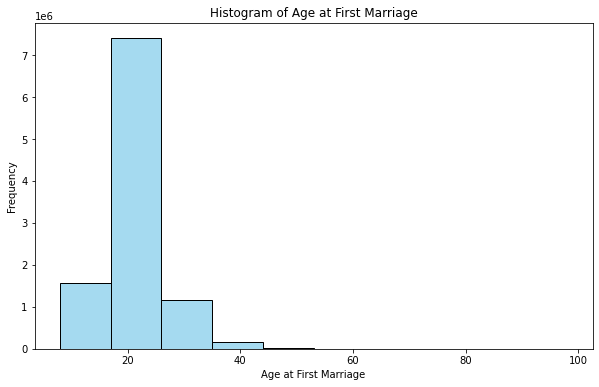

In [15]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['age_at_marriage'], bins=10, kde=False, color='skyblue', edgecolor='black')

plt.title('Histogram of Age at First Marriage')
plt.xlabel('Age at First Marriage')
plt.ylabel('Frequency')

plt.grid(False)
plt.show()

The age at first marriage is skewed to the right with many individuals getting married about 20 years.A right-skewed histogram of age at first marriage indicates that most individuals are marrying at younger ages, but there is a long tail extending towards older ages.

In [16]:
# Mapping for the education levels
education_mapping = {
    1: 'Preschool',
    2: 'Primary-school',
    3: 'Secondary',
    4: 'Technical college',
    5: 'University'
}

education_age_grouped = df.groupby('highest_education')['age_at_marriage'].agg(
    ['mean', 'median','count']
).reset_index()


education_age_grouped['highest_education'] = education_age_grouped['highest_education'].map(education_mapping)

print("Summary of Age at First Marriage by Highest Education Level")
print(tabulate(education_age_grouped, headers='keys', tablefmt='pretty', showindex=False))

Summary of Age at First Marriage by Highest Education Level
+-------------------+--------------------+--------+---------+
| highest_education |        mean        | median |  count  |
+-------------------+--------------------+--------+---------+
|     Preschool     | 20.23346382767661  |  19.0  | 112904  |
|  Primary-school   |  20.4047519741933  |  20.0  | 4457137 |
|     Secondary     | 21.609568584169892 |  20.0  | 2790695 |
| Technical college | 23.140605523160968 |  22.0  | 119533  |
|    University     | 25.30795173033027  |  25.0  | 369756  |
+-------------------+--------------------+--------+---------+


The table above shows a clear trend between education level and the age at first marriage. Individuals with only preschool education marry the earliest, with an average age of around 20.2 years. As education increases, the age at first marriage also rises. Those with primary-school education marry at an average age of 20.4, while individuals with secondary education marry slightly later, at 21.6 years on average.

For those with technical college education, the average age increases further to 23.1 years, and university graduates have the latest average age at first marriage at 25.3 years. This trend suggests that higher levels of education are associated with a delay in marriage, likely due to factors like career and financial stability. In contrast, lower education levels are linked to earlier marriages.

# Task-4-Prepare data for ML model building

To predict early marriage, the target variable is created from age at first marriage. A threshold age, such as 20 years, is used to define early marriage. If someone marries at or before this age, the target variable is assigned a value of 1 (early marriage). If they marry after this age, the target variable is assigned a value of 0 (late marriage). This converts the age at first marriage into a binary classification variable.

In order to gain an initial understanding of which variables might be important for classification, I used a Random Forest model with 10 trees. This helped me get a rough idea of the variables that could potentially be useful in predicting early marriage, even though the results were not highly accurate. The Random Forest model provided an overview of the feature importances, giving me insight into which variables were likely contributing the most to the classification task. While this approach didn't provide precise feature rankings, it served as a useful starting point to identify the key features that might be worth further exploration and refinement in the modeling process. 

As for communes, their inclusion depends on their significance. If communes represent smaller geographic units with distinct socio-cultural characteristics that influence marriage timing, they could provide valuable insights. However, if the number of communes is large or their information overlaps with districts or regions, it might introduce redundancy.

# Prepare Data for ML

## Generate Target Variable for Prediction

In [17]:
# ====================================
# ADD EARLY MARRIAGE VARIABLE
# ====================================
# if age_married < 18, then early_marriage = 1
df['early_marriage'] = df['age_at_marriage'].apply(lambda x: 1 if x < EARLY_MARRIAGE_AGE_THRESHOLD else 0)

## Drop Observations
- In this datasets, the marriage variabels are available for all individuals who are 12 years old or older. We can drop the observations where the marriage status is not available.
- Age at first marriage also makes sense for people who are currently married, divorced or widowed.

In [18]:
# Keep only individuals who are 12 years and above
df_marr = df[df['age'] >= 12]

In [19]:
# Keep only individuals who were ever married (currently married, divorced or widowed)
df_marr = df_marr[df_marr['marital_status'] != 1]

## Features for Prediction

In [20]:
def convert2int(x):
    try:
        # Check if value is a float and has no decimal part
        if isinstance(x, float) and x.is_integer():
            return int(x)
        elif isinstance(x, int):  # Handle integers directly
            return x
        else:
            return np.nan  # Return NaN for anything else
    except:
        return np.nan

In [21]:
# List of columns to apply the conversion to (float columns that should be integers)
columns_to_convert = [
    'age', 'marital_status', 'working_status', 'highest_education', 
    'years_completed', 'school_attendance', 'age_at_marriage', 
    'local_lnguage', 'french', 'english', 'other_language', 
    'local_language_literacy', 'french_literacy', 'english_literacy', 
    'other_language_literacy',
]

# Apply the conversion to those columns
df_marr[columns_to_convert] = df_marr[columns_to_convert].applymap(convert2int)

In [22]:
# ====================================
# PREPARE DATA FOR ML MODELS
# ====================================
# Convert columns with categorical data to pd.category type.
# Ensure that the categorical columns are of type int

# Target variable for prediction
target_variable = 'early_marriage'

# Features to use for prediction
feature_columns = [
    'PROVINCE', 'REGION', 'DISTRICT', 'COMMUNE', 
    'marital_status', 'sex', 'highest_education','school_attendance','num_children',
    'num_elderly'
]
# Set categorical features to pd.Categorical
# Convert columns to categorical
categorical_columns = ['MILIEU','marital_status', 'working_status','head_household', 'highest_education', 'school_attendance',
                      'local_language_literacy', 'french_literacy', 'english_literacy', 'other_language_literacy',
                      'local_lnguage', 'french', 'english', 'other_language', 'sex', 'is_child', 'is_elderly','years_completed']

for col in categorical_columns:
    df_marr[col] = pd.Categorical(df_marr[col])
    
for col in categorical_columns:
    df_marr[col] = df_marr[col].cat.codes

In [23]:
# ====================================
# DEAL WITH MISSING VALUES
# ====================================
# Fill missing values with the mode for categorical variables
# and mean/median for continuous variables
continuous_columns = ['age', 'age_at_marriage']

for col in categorical_columns:
    mode_value = df_marr[col].mode()[0]  # Get the most frequent value (mode)
    df_marr[col].fillna(mode_value, inplace=True)
    
for col in continuous_columns:
    if df_marr[col].dtype == 'float64' or df_marr[col].dtype == 'int64':
        median_value = df_marr[col].median()  # Use median for continuous variables
        df_marr[col].fillna(median_value, inplace=True)

In [24]:
# ============================================
# DEAL WITH OUTLIERS IN CONTINUOUS VARIABLES
# =============================================
# Age, drop all observations with age > 100
df_marr = df_marr[df_marr['age'] <= 100]

# HH_SIZE, drop all observations with hh_size > 20
df_marr = df_marr[df_marr['hh_size'] <= 20]

# NUM_CHILDREN, drop all observations with num_children > 15
df_marr = df_marr[df_marr['num_children'] <= 15]

# NUM_ELDERLY, drop all observations with num_elderly > 15
df_marr = df_marr[df_marr['num_elderly'] <= 15]

In [25]:
# ============================================
# ONE-HOT ENCODING FOR CATEGORICAL VARIABLES
# ============================================
# One-hot encode the categorical variables
# using pd.get_dummies function
# Make sure you one-hot encode all the categorical variables
df_encoded = pd.get_dummies(df_marr, columns=categorical_columns, drop_first=True)
# Convert True/False to 1/0

In [28]:
target = 'early_marriage'

X = df_encoded.drop(columns=[target])
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RF(n_estimators=10, random_state=42) 
rf.fit(X_train, y_train)

# Get the feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame with feature names and their importance scores
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance and get the top 20 most important features
top_20_features = features_df.sort_values(by='Importance', ascending=False).head(20)

# Print the top 20 most important features
print("Top 20 Most Important Features:")
print(top_20_features)

Top 20 Most Important Features:
                      Feature  Importance
7             age_at_marriage        0.84
6                         age        0.05
54                      sex_1        0.02
21           head_household_1        0.02
3                     COMMUNE        0.01
4                       hh_id        0.01
2                    DISTRICT        0.01
38  local_language_literacy_0        0.00
39  local_language_literacy_1        0.00
5                    indiv_id        0.00
9                num_children        0.00
8                     hh_size        0.00
35        school_attendance_1        0.00
0                    PROVINCE        0.00
11                   MILIEU_1        0.00
41          french_literacy_1        0.00
16           working_status_3        0.00
31        highest_education_1        0.00
48                   french_0        0.00
50                  english_0        0.00


In [29]:
important_features = ['age', 'sex_1', 'head_household_1', 'COMMUNE', 'DISTRICT','french_literacy_1','hh_size',
                     'working_status_3','MILIEU_1', 'highest_education_3', 'french_1','early_marriage']

df_important_features = df_encoded[important_features]

In [30]:
print(df_important_features)

          age  sex_1  head_household_1  COMMUNE  DISTRICT  french_literacy_1  \
6          49      1                 1    11101       111                  0   
8          77      1                 0    11101       111                  0   
9          18      1                 0    11101       111                  0   
11         45      1                 1    11101       111                  0   
15         43      0                 0    11101       111                  0   
...       ...    ...               ...      ...       ...                ...   
25674184   35      1                 1    62414       624                  1   
25674187   31      1                 0    62418       624                  0   
25674188   18      1                 1    62418       624                  1   
25674190   55      1                 1    62416       624                  1   
25674193   25      1                 1    62413       624                  1   

          hh_size  working_status_3  MI

# Task 5 - Model Building

In [31]:
def random_forest_with_sklearn(df_encoded, num_estimators=100):
    # Define the target variable and features
    target_var = 'early_marriage'
    features = df_important_features.columns[df_important_features.columns != target_var]
    
    # Split the data into training and testing sets
    X = df_important_features[features]
    y = df_important_features[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Random Forest model
    rf_model = RF(n_estimators=num_estimators, random_state=42, n_jobs=-1)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)

    return rf_model

In [32]:
random_forest_with_sklearn(df_important_features)

Accuracy: 0.7930157638786258
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87   2446357
           1       0.55      0.42      0.48    706801

    accuracy                           0.79   3153158
   macro avg       0.70      0.66      0.67   3153158
weighted avg       0.78      0.79      0.78   3153158



RandomForestClassifier(n_jobs=-1, random_state=42)

In [33]:
def evaluate_models_sklearn(df_important_features):
    # Define the target variable and features
    target_var = 'early_marriage'
    features = df_important_features.columns[df_important_features.columns != target_var]

    # Split the data into training and testing sets
    X = df_important_features[features]
    y = df_important_features[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the models
    models = {
        "Logistic Regression": LR(max_iter=100, random_state=42,solver='saga'),
        "Random Forest": RF(n_estimators=100, random_state=42, n_jobs=-1),
        "Gradient Boosting": GBM(n_estimators=100, random_state=42),
        "Extra Trees": ETC(n_estimators=100, random_state=42, n_jobs=-1)
    }

    # Train and evaluate each model
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append([name, accuracy])

    # Print the results in a tabular format
    print(tabulate(results, headers=["Model", "Accuracy"], tablefmt="pretty"))

In [34]:
# Build and evaluate the models using the df_marr2_dummies DataFrame
evaluate_models_sklearn(df_important_features)

/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


+---------------------+--------------------+
|        Model        |      Accuracy      |
+---------------------+--------------------+
| Logistic Regression | 0.7793856191158197 |
|    Random Forest    | 0.7930157638786258 |
|  Gradient Boosting  | 0.815785951734737  |
|     Extra Trees     | 0.7938609482937423 |
+---------------------+--------------------+


In [35]:
from pyspark.ml.classification import RandomForestClassifier
def evaluate_models_spark(df_important_features, target_var):
    """
    Evaluate multiple machine learning models using Spark MLlib on the given DataFrame.

    Parameters:
    ----------
    df : pyspark.sql.DataFrame
        The input DataFrame containing features and the target variable.
    target_var : str
        The name of the target variable column.

    Returns:
    -------
    None
    """
    # Define the features
    features = [col for col in df_important_features.columns if col != target_var]

    # Assemble features into a single vector
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    df_important_features = assembler.transform(df_important_features).select("features", target_var)

    # Split the data into training and testing sets
    train_df, test_df = df_important_features.randomSplit([0.7, 0.3], seed=42)

    # Initialize models
    models = {
    "Logistic Regression": LogisticRegression(maxIter=25).setFeaturesCol("features").setLabelCol(target_var),
    "Random Forest": RandomForestClassifier(numTrees=50, seed=42).setFeaturesCol("features").setLabelCol(target_var),
    "Gradient Boosting": GBTClassifier(maxIter=50, seed=42).setFeaturesCol("features").setLabelCol(target_var),
    "Decision Tree": DecisionTreeClassifier(seed=42).setFeaturesCol("features").setLabelCol(target_var),
}

    # Initialize evaluator
    evaluator = MulticlassClassificationEvaluator(labelCol=target_var, predictionCol="prediction", metricName="accuracy")

    # Train and evaluate each model
    results = []
    for name, model in models.items():
        # Train the model
        trained_model = model.fit(train_df)

        # Make predictions
        predictions = trained_model.transform(test_df)

        # Evaluate accuracy
        accuracy = evaluator.evaluate(predictions)

        # Append results
        results.append([name, accuracy])

    # Print results in a tabular format
    from tabulate import tabulate
    print(tabulate(results, headers=["Model", "Accuracy"], tablefmt="pretty"))


In [36]:
# Convert pandas DataFrame to PySpark DataFrame
df_spark = spark.createDataFrame(df_important_features)

In [43]:
evaluate_models_spark(df_spark, "early_marriage")

+---------------------+--------------------+
|        Model        |      Accuracy      |
+---------------------+--------------------+
| Logistic Regression | 0.7989872746402189 |
|    Random Forest    | 0.8014321778828876 |
|  Gradient Boosting  | 0.8152337645324725 |
|    Decision Tree    | 0.8031247056077034 |
+---------------------+--------------------+


# Task 5 - -Build ML Model with Scikit-learn and spark - Discussion
The results from the models indicate solid performance, with Gradient Boosting achieving the highest accuracy at 81.53%, followed closely by Decision Tree at 80.34% and Random Forest at 80.14%. These ensemble models perform better than Logistic Regression, which had the lowest accuracy at 79.89%. This suggests that models like Gradient Boosting and Random Forest, which can handle complex patterns and non-linear relationships, are more effective for predicting early marriage compared to simpler models like Logistic Regression.



In [41]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import pandas as pd

# Prepare the features
feature_columns = ['age', 'sex_1', 'head_household_1', 'COMMUNE', 'DISTRICT','french_literacy_1','hh_size',
                     'working_status_3','MILIEU_1', 'highest_education_3', 'french_1','early_marriage']  # Example features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the GBT model
gbt = GBTClassifier(featuresCol="features", labelCol="early_marriage", maxIter=10)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Fit the model
model = pipeline.fit(df_spark)
gbt_model = model.stages[-1]

# Get feature importances
importances = gbt_model.featureImportances

feature_importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances.toArray()
})

In [42]:
# Sort by importance and get top 5 features
top_5_features = feature_importances.sort_values(by='Importance', ascending=False).head(6)

print(top_5_features['Feature'])

11         early_marriage
6                 hh_size
1                   sex_1
2        head_household_1
3                 COMMUNE
9     highest_education_3
Name: Feature, dtype: object


The top 5 predictors of early marriage are as follows: household size (hh_size), which suggests that larger households may be associated with earlier marriages; sex_1, where being male is linked to a higher likelihood of early marriage; head_household_1, indicating that individuals who are heads of their households tend to marry earlier, possibly due to increased responsibility; COMMUNE, which reflects the geographic region and its influence on marriage practices; and highest_education_3, where having a secondary level of education is a key factor, with those possessing this level of education often marrying at a younger age.